# Week 2 - Linear Regression 2 - Lasso, Ridge, and Elastic Net Regression

#### <font color='plum'> RESPONSES IN THIS COLOR


For Week 2, include concepts such as linear regression with lasso, ridge, and elastic net regression. 

- **Lasso regression** is a *regularized* version of regression. Instead of minimizing the error of a prediction relative to a true target value, it tries to *minimize a regularization term*: `λ∑|wᵢ|`, where constant (lambda) is multiplied by the <u>sum of the *absolute values of the coefficients* (L1 Regularization)</u>; the goal is to make the coefficients as small as possible. 
    - Lasso handles multicollinearity by, in essence, dropping one of the features at random.
    - Lasso penalizes small coefficients in the same way as large ones, so it will reduce the number of non-zero coeffs


- **Ridge regression** is like lasso regression, but instead of using the sum of the absolute values, it uses the <u>sum of the *squares of the coefficients* (L2 Regularization)</u>. 
    - Ridge regression tends to keep many positive coefficients
    - usually handles *multicollinearity* by assigning a nonzero term to each feature. 


- **Elastic net regression** uses an *alpha parameter* to interpolate between lasso and ridge, which allows you to perform feature selection (like lasso) but also handle multicollinearity in the way that Ridge regression does. 

##### *Selecting optimal `λ` parameter*
In applying both ridge and lasso regression, the way to select the lambda parameter is to try different values, using some sort of hyperparameter search. For example, you could use cross-validation with a grid search or random search. It might be best to try lambda values in a logarithmic space, i.e., trying ﻿lambda﻿ = 100, 10, 1, 0.1, 0.01, etc. 


# Imports

In [16]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
import kagglehub 
import time
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import (
    train_test_split, 
    RepeatedKFold,
    cross_val_score
)

from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    root_mean_squared_error,
    accuracy_score, 

)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_regression
from datetime         import datetime, timedelta
from tqdm             import tqdm
from typing import Any, Dict, List, Union, Tuple
from sklearn.base import BaseEstimator
from collections import Counter
from scipy.stats import randint
# from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline

from kagglehub              import KaggleDatasetAdapter

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

# Utility Functions

In [17]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [18]:
def get_linreg_stats(model_name, y_test, y_pred):
    """
    Computes regression statistics for a linear regression model.

    Parameters:
        y_test (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: A dictionary containing the computed regression statistics.
    """
    mse     = mean_squared_error(y_test, y_pred)
    rmse    = root_mean_squared_error(y_test, y_pred)
    r2      = r2_score(y_test, y_pred)

    return {
        'Model':    model_name,
        "MSE":      mse,
        "RMSE":     rmse,
        "R^2":      r2
    }


In [19]:
def plot_regularization_scores(alphas, scores_list_1, scores_list_2):
    """
    Plots R^2 and MSE scores against alpha values.

    Parameters:
        alphas (array-like): Array of alpha values.
        r2_scores (array-like): Corresponding R^2 scores.
        mse_scores (array-like): Corresponding MSE scores.
    """
    # Plot R^2 and MSE vs alpha
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(alphas, scores_list_1, marker='o', markersize = 2 )
    plt.xscale('log')
    plt.xlabel('Alpha (λ)')
    plt.ylabel('Mean R² Score')
    plt.title('R² vs Alpha')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(alphas, scores_list_2, marker='o', color='red', markersize = 2 )
    plt.xscale('log')
    plt.xlabel('Alpha (λ)')
    plt.ylabel('Mean MSE')
    plt.title('MSE vs Alpha')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 1. Dataset:  Parkinsons Telemonitoring

Tsanas, A. & Little, M. (2009). Parkinsons Telemonitoring [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5ZS3N.

https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. The rows of the CSV file contain an instance corresponding to one voice recording. There are around 200 recordings per patient, the subject number of the patient is identified in the first column

- Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures. 
- Each row corresponds to one of 5875 voice recordings from these individuals. 
- The main aim of the data is to <font color = 'cyan'> predict the motor and total UPDRS scores (`motor_UPDRS` and `total_UPDRS`) from the 16 voice measures.

### Load & Clean

In [20]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 
  
# metadata 
parkinsons_telemonitoring.metadata

{'uci_id': 189,
 'name': 'Parkinsons Telemonitoring',
 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring',
 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv',
 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset",
 'area': 'Health and Medicine',
 'tasks': ['Regression'],
 'characteristics': ['Tabular'],
 'num_instances': 5875,
 'num_features': 19,
 'feature_types': ['Integer', 'Real'],
 'demographics': ['Age', 'Sex'],
 'target_col': ['motor_UPDRS', 'total_UPDRS'],
 'index_col': ['subject#'],
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2009,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C5ZS3N',
 'creators': ['Athanasios Tsanas', 'Max Little'],
 'intro_paper': {'ID': 229,
  'type': 'NATIVE',
  'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests",
  'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig',
  'venue

In [21]:
# variable information 
parkinsons_telemonitoring.variables


,name,role,type,demographic,description,units,missing_values
0,subject#,ID,Integer,None,Integer that uniquely identifies each subject,None,no
1,age,Feature,Integer,Age,Subject age,None,no
2,test_time,Feature,Continuous,None,Time since recruitment into the trial. The int...,None,no
3,Jitter(%),Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
4,Jitter(Abs),Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
5,Jitter:RAP,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
6,Jitter:PPQ5,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
7,Jitter:DDP,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
8,Shimmer,Feature,Continuous,None,Several measures of variation in amplitude,None,no
9,Shimmer(dB),Feature,Continuous,None,Several measures of variation in amplitude,None,no


In [22]:
# concatenate X and first column of y
X = pd.concat([X, y['motor_UPDRS']], axis=1)
y = y.drop(columns=['motor_UPDRS'])


In [23]:
X

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS
0,72,5.6431,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0,28.199
1,72,12.6660,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0,28.447
2,72,19.6810,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0,28.695
3,72,25.6470,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0,28.905
4,72,33.6420,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0,29.187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,142.7900,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,0,22.485
5871,61,149.8400,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,0,21.988
5872,61,156.8200,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,0,21.495
5873,61,163.7300,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,0,21.007


In [24]:
y

,total_UPDRS
0,34.398
1,34.894
2,35.389
3,35.810
4,36.375
...,...
5870,33.485
5871,32.988
5872,32.495
5873,32.007


## OLS

In [25]:
# Define the cross-validation strategy
splits  = 5
repeats = 5
cv      = RepeatedKFold(n_splits = splits, n_repeats = repeats, random_state = random_state)
print("Total split iterations:", cv.get_n_splits(X, y))

# Create the model
model   = LinearRegression()

# Evaluate the model using cross-validation
# 'r2' is the default scoring for LinearRegression
# set of 25 scores (5 folds x 5 repeats)

scores  = cross_val_score(model, X, y, scoring = 'r2', cv = cv)
mean_r2 = np.mean(scores)
print(f"Mean R^2 Score (5-fold, 5 repeats): {mean_r2:.4f}")

mse_scores  = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
mean_mse    = np.mean(mse_scores)
print(f"Mean MSE (5-fold, 5 repeats): {mean_mse:.4f}")


results_dict = {
    'Model': 'LinReg_Baseline',
    'Method': f'Repeated {splits}-Fold CV',
    'Best_R²': mean_r2,
    'Best_MSE': mean_mse,
    # 'alpha': None
}

results_df = pd.DataFrame([results_dict])
results_df

Total split iterations: 25
Mean R^2 Score (5-fold, 5 repeats): 0.9066
Mean MSE (5-fold, 5 repeats): 10.6818


,Model,Method,Best_R²,Best_MSE
0,LinReg_Baseline,Repeated 5-Fold CV,0.9066,10.681795


## Lasso

**Regularization** is a technique used to **prevent overfitting** by adding a penalty term to the model's loss function to discourage the model from learning overly complex relationships and help it generalize better to new data. 
`alpha (α)` in scikit-learn's Lasso implementation is equivalent to the regularization parameter `λ (lambda)` in the traditional formulation of Lasso regression

`alpha (α)` is a hyperparameter that controls the strength of the regularization penalty. It's the 'regularization strength'. A higher alpha means more regularization --> more coefficients being shrunk to zero (a form of feature selection), while a lower alpha allows the model to fit the data more closely.

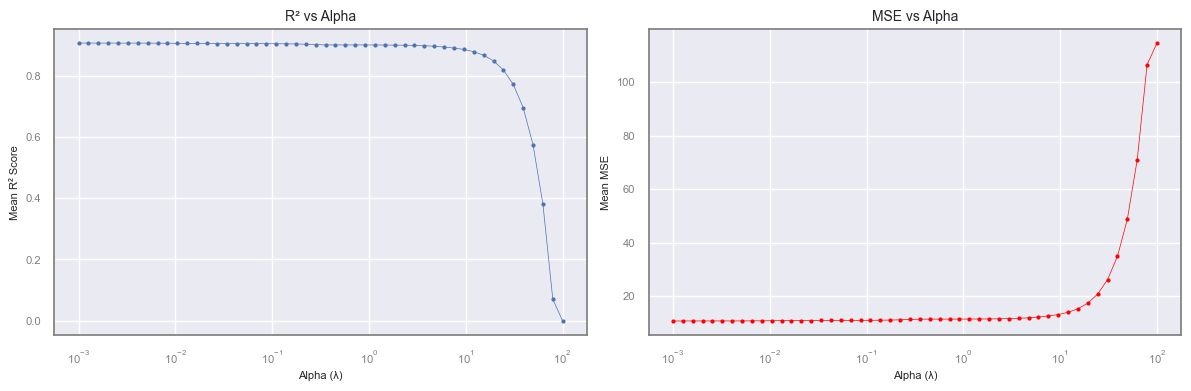

,Model,Method,Best_R²,Best_MSE,Best_alpha_R²,Best_alpha_MSE
0,LinReg_Baseline,Repeated 5-Fold CV,0.906600,10.681795,NaN,NaN
1,Lasso,Repeated 5-Fold CV,0.906028,10.746323,0.001,0.001


In [26]:

cv = RepeatedKFold(n_splits      = splits, 
                   n_repeats     = repeats, 
                   random_state  = random_state
                   )

r2_scores   = []
mse_scores  = []

alphas = np.logspace(-3, 2, 50)

# Iterate over alpha values
for alpha in alphas:
    model   = Lasso(alpha=alpha, max_iter=10000)
    r2      = cross_val_score(model, X, y, scoring='r2', cv=cv)
    mse     = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    r2_scores.append(np.mean(r2))
    mse_scores.append(np.mean(mse))

# Find best alpha values
best_r2_idx     = np.argmax(r2_scores)
best_mse_idx    = np.argmin(mse_scores)

best_alpha_r2   = alphas[best_r2_idx]
best_alpha_mse  = alphas[best_mse_idx]
best_r2         = r2_scores[best_r2_idx]
best_mse        = mse_scores[best_mse_idx]

plot_regularization_scores(alphas, r2_scores, mse_scores)


# Populate results_dict with best results
results_dict = {
    'Model': 'Lasso',
    'Method': f'Repeated {splits}-Fold CV',
    'Best_alpha_R²':    best_alpha_r2,
    'Best_R²':          best_r2,
    'Best_alpha_MSE':   best_alpha_mse,
    'Best_MSE':         best_mse
}

# Create results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
results_df


## Ridge Regression

In [27]:
# alphas = np.logspace(-3, 2, 50)
# print(alphas)

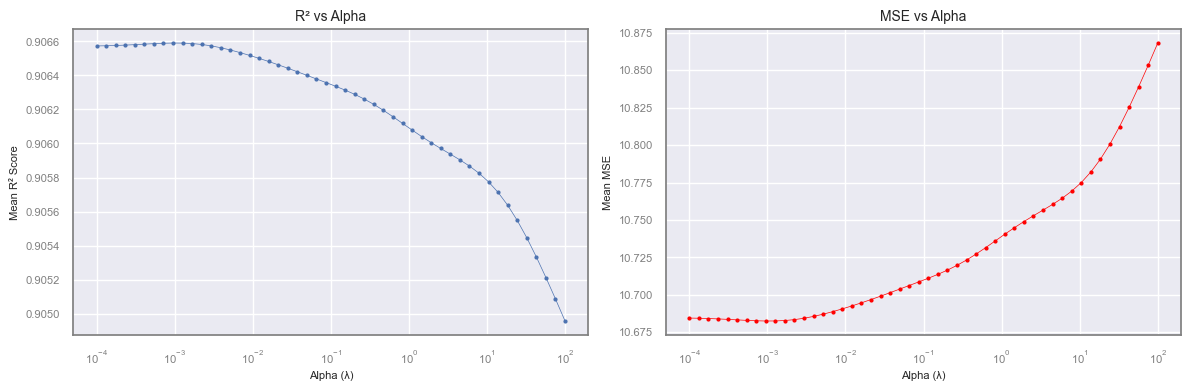

,Model,Method,Best_R²,Best_MSE,Best_alpha_R²,Best_alpha_MSE
0,LinReg_Baseline,Repeated 5-Fold CV,0.906600,10.681795,NaN,NaN
1,Lasso,Repeated 5-Fold CV,0.906028,10.746323,0.001000,0.001000
2,Ridge,Repeated 5-Fold CV,0.906590,10.682510,0.000954,0.000954


In [28]:

cv = RepeatedKFold(n_splits      = splits, 
                   n_repeats     = repeats, 
                   random_state  = random_state
                   )

r2_scores   = []
mse_scores  = []

alphas = np.logspace(-4, 2, 50)

# Iterate over alpha values
for alpha in alphas:
    model   = Ridge(alpha=alpha, max_iter=10000)
    r2      = cross_val_score(model, X, y, scoring='r2', cv=cv)
    mse     = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    r2_scores.append(np.mean(r2))
    mse_scores.append(np.mean(mse))

# Find best alpha values
best_r2_idx     = np.argmax(r2_scores)
best_mse_idx    = np.argmin(mse_scores)

best_alpha_r2   = alphas[best_r2_idx]
best_alpha_mse  = alphas[best_mse_idx]
best_r2         = r2_scores[best_r2_idx]
best_mse        = mse_scores[best_mse_idx]

plot_regularization_scores(alphas, r2_scores, mse_scores)


# Populate results_dict with best results
results_dict = {
    'Model': 'Ridge',
    'Method': f'Repeated {splits}-Fold CV',
    'Best_alpha_R²':    best_alpha_r2,
    'Best_R²':          best_r2,
    'Best_alpha_MSE':   best_alpha_mse,
    'Best_MSE':         best_mse
}

# Assuming results_df is a pre-existing DataFrame
results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
results_df

## Elastic Net Regression

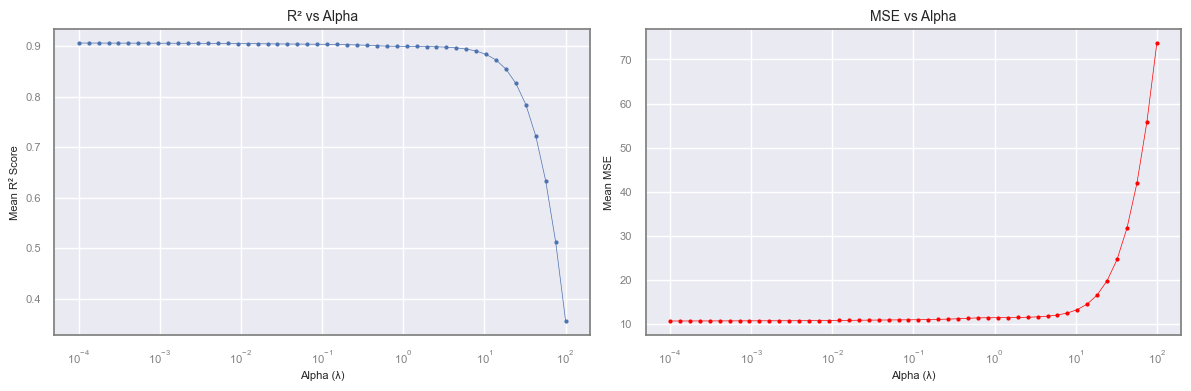

,Model,Method,Best_R²,Best_MSE,Best_alpha_R²,Best_alpha_MSE
0,LinReg_Baseline,Repeated 5-Fold CV,0.906600,10.681795,NaN,NaN
1,Lasso,Repeated 5-Fold CV,0.906028,10.746323,0.001000,0.001000
2,Ridge,Repeated 5-Fold CV,0.906590,10.682510,0.000954,0.000954
3,elasticNet,Repeated 5-Fold CV,0.906261,10.719734,0.000100,0.000100


In [29]:
cv = RepeatedKFold(n_splits      = splits, 
                   n_repeats     = repeats, 
                   random_state  = random_state
                   )

r2_scores   = []
mse_scores  = []

alphas      = np.logspace(-4, 2, 50)
l1_ratio    = 0.5

# Iterate over alpha values
for alpha in alphas:
    model   = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 10000)
    r2      = cross_val_score(model, X, y, scoring='r2', cv=cv)
    mse     = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
    r2_scores.append(np.mean(r2))
    mse_scores.append(np.mean(mse))

# Find best alpha values
best_r2_idx     = np.argmax(r2_scores)
best_mse_idx    = np.argmin(mse_scores)

best_alpha_r2   = alphas[best_r2_idx]
best_alpha_mse  = alphas[best_mse_idx]
best_r2         = r2_scores[best_r2_idx]
best_mse        = mse_scores[best_mse_idx]

plot_regularization_scores(alphas, r2_scores, mse_scores)


# Populate results_dict with best results
results_dict = {
    'Model': 'elasticNet',
    'Method': f'Repeated {splits}-Fold CV',
    'Best_alpha_R²':    best_alpha_r2,
    'Best_R²':          best_r2,
    'Best_alpha_MSE':   best_alpha_mse,
    'Best_MSE':         best_mse
}

# Create results DataFrame
results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
results_df

## Summary

In [30]:
results_df

# print(results_df)

,Model,Method,Best_R²,Best_MSE,Best_alpha_R²,Best_alpha_MSE
0,LinReg_Baseline,Repeated 5-Fold CV,0.906600,10.681795,NaN,NaN
1,Lasso,Repeated 5-Fold CV,0.906028,10.746323,0.001000,0.001000
2,Ridge,Repeated 5-Fold CV,0.906590,10.682510,0.000954,0.000954
3,elasticNet,Repeated 5-Fold CV,0.906261,10.719734,0.000100,0.000100


## NOTES

`cross_val_score` handles splitting and fitting internally. It automatically:

- Splits the data into training and validation sets based on the cross-validation strategy (cv).
- Fits the model on the training set.
- Evaluates it on the validation set.
- Repeats this process for each fold and each repeat (in your case, 5 folds × 5 repeats = 25 evaluations).
- Returns an array of scores (e.g., R² or negative MSE) for each fold.


No need for `train_test_split` or manual `model.fit`: Since `cross_val_score` does all the splitting and fitting for you, manually calling train_test_split or model.fit would be redundant and could even interfere with the cross-validation process.

### <font color='gold'> Why does Lasso regression end up dropping some coefficients?</font> 

<font color='plum'> 

Lasso tends to make some coefficients go to zero. For example, suppose the regularization term is ﻿lambda open parentheses beta subscript 1 plus beta subscript 2 plus beta subscript 3 close parentheses﻿. Then, if we reduce ﻿beta subscript 1﻿ by one point, how much does the fit worsen? If it worsens by lambda points or less, then we should perhaps keep reducing ﻿beta subscript 1﻿ until it reaches zero. That’s because the fit gets better by lambda points (due to the regularization term) and then worse by less than lambda points for a net benefit. In that case, maybe it’s not worth it to have a ﻿beta subscript 1﻿ after all.

Lasso handles multicollinearity by, in essence, dropping one of the features at random

### <font color='gold'> Why does Ridge regression end up NOT dropping coefficients? </font>

<font color='plum'> 
Ridge regression does not drop coefficients because of the nature of its penalty term, known as **L2 regularization**.

The objective of Ridge regression is to minimize the following function:

$$\text{Minimizing function} = \text{Residual Sum of Squares} + \alpha \times \sum_{j=1}^{p} \beta_j^2$$

In this equation:
* **Residual Sum of Squares (RSS)**: This measures the sum of the squared differences between the actual and predicted values.
* **$\alpha \times \sum_{j=1}^{p} \beta_j^2$**: This is the L2 penalty term. The penalty is the **squared magnitude** of the coefficients ($\beta_j$), and $\alpha$ controls its strength.

#### Why the L2 Penalty Prevents Coefficients from Reaching Zero
The squared term in the L2 penalty means that as a coefficient approaches zero, the penalty for it also approaches zero very slowly. The penalty becomes infinitesimally small as the coefficient gets closer to zero but never quite reaches it unless the coefficient is exactly zero to begin with.

This is best understood with a **geometric interpretation**. 

* **Ridge Regression (L2):** The constraint on the coefficients is a circle (or a sphere in higher dimensions). The model's optimal solution is the point where the elliptical contour of the RSS (the original OLS solution) touches the circular constraint. Because the circle has a smooth, curved boundary, the contact point will almost always occur where none of the coefficients are exactly zero.

* **Lasso Regression (L1):** The constraint is a diamond shape. This shape has sharp corners at the axes. When the elliptical RSS contour touches the diamond at one of these corners, the corresponding coefficient is set to exactly zero. This is what enables Lasso to perform feature selection.

In short, the squared penalty of Ridge regression shrinks all coefficients toward zero proportionally but doesn't have the mathematical property to force them to become exactly zero, so it doesn't perform feature selection.


### <font color='gold'> When would you prefer to use Lasso regression?</font> 

<font color='plum'> 
When simplifying a model by performing **automatic feature selection** b/c we believe that many features are irrelevant or redundant. Lasso is particularly effective in two main scenarios.

1. High-Dimensional Data 
Lasso is ideal for datasets with a very **large number of features (p)** compared to the **number of observations (n)**, also known as the "**large p, small n**" problem. This is common in fields like genomics, where you might have thousands of genes for a small number of patients. In this situation, standard linear regression would likely overfit the data. Lasso helps by shrinking the coefficients of less important features to exactly zero, effectively dropping them from the model and creating a more **sparse** and **interpretable** result.

2. Feature Selection 
Beyond just a large number of features, you'd choose Lasso if you suspect that only a **small subset of features** are truly important for the prediction, and the rest are just noise. The L1 penalty's ability to drive coefficients to zero makes it a powerful tool for automatically identifying and selecting the most relevant predictors. This simplifies the model, making it easier to understand and less prone to overfitting.

A key drawback of Lasso to consider is its behavior with **multicollinearity** (highly correlated features). If two or more features are highly correlated, Lasso will arbitrarily select just one of them and set the others' coefficients to zero. If you have groups of correlated features and want to keep all of them in the model (but with shrunken coefficients), **Elastic Net** might be a better choice as it combines the strengths of both Lasso and Ridge.


### <font color='gold'> When would you prefer to use Ridge regression?</font>

<font color='plum'> 
You would prefer to use **Ridge regression** when your data has **multicollinearity** and you want to shrink coefficients to improve model stability without eliminating any features. Ridge regression is especially useful in two key situations.

 1. Multicollinearity 📊
Ridge regression is the preferred choice when your predictor variables are highly correlated. Standard linear regression models can become unstable and have very large, sensitive coefficients when multicollinearity is present. The L2 penalty in Ridge regression addresses this by shrinking the coefficients of correlated features towards each other, distributing the effect and stabilizing the model. This makes the model more robust to changes in the data.

 2. When You Don't Want to Drop Features 🔎
Unlike Lasso, Ridge regression does not set coefficients to exactly zero. Instead, it shrinks them. This is beneficial if you believe that all the features in your model are important to some extent and you don't want to lose any of them. Ridge preserves all features in the model, making it a good choice for scenarios where interpretability relies on understanding the influence of every variable. 

In short, if you have correlated features and a goal of creating a stable model that includes all predictors, Ridge regression is an excellent choice. If feature selection is a primary goal, Lasso or Elastic Net would be more appropriate.

### <font color='gold'> When would you prefer to use regression with no regularization? </font>

<font color='plum'> 

Use regression with no regularization, such as **Ordinary Least Squares (OLS) regression**, when:
-  dataset has a small number of features and 
- you are confident that there is little to no multicollinearity or risk of overfitting.

**Ideal Scenarios for OLS**
OLS regression is the simplest and most common form of linear regression. It's often the baseline model for a problem. You would stick with it when:

* **Low Number of Features**: Your model has only a handful of predictor variables. With fewer features, the risk of overfitting is generally lower.
* **Low Multicollinearity**: The predictor variables are not highly correlated with each other. High correlation can make the model unstable and its coefficients hard to interpret.
* **Emphasis on Interpretability**: The primary goal is to understand the exact relationship between each predictor and the target variable. OLS provides straightforward, unpenalized coefficient values that are easy to interpret. Regularized methods like Lasso and Ridge shrink these coefficients, making their direct interpretation more complex.
* **Sufficiently Large Sample Size**: The number of observations is significantly larger than the number of features. This helps the model to generalize well without the need for regularization.

In essence, if your model is simple, your data is clean, and you don't anticipate overfitting or multicollinearity, OLS regression is the most direct and interpretable choice. It serves as a good starting point before considering more complex regularized models.